# Practice Gridsearch and Multinomial Models with SF Crime Data


---

### Multinomial logistic regression models

So far, we have been using logistic regression for binary problems where there are only two class labels. Logistic regression can be extended to dependent variables with multiple classes.

There are two ways sklearn solves multiple-class problems with logistic regression: a multinomial loss or a "one vs. rest" (OvR) process where a model is fit for each target class vs. all the other classes. 

**Multinomial vs. OvR**
- (M) 'k-1' models with 1 reference category
- (OvR) 'k*(k-1)/2' models

You will use the gridsearch in conjunction with multinomial logistic to optimize a model that predicts the category (type) of crime based on various features captured by San Francisco police departments.

**Necessary lab imports**

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Read in the data

In [2]:
crime_csv = 'sf_crime_train.csv'

In [3]:
#read in the data using pandas
sf_crime = pd.read_csv(crime_csv)
sf_crime.drop('DayOfWeek',axis=1,inplace=True)
sf_crime.head()

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y
0,5/13/15 23:53,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,5/13/15 23:53,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,5/13/15 23:33,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,5/13/15 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,5/13/15 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
# check the shape of your dataframe
sf_crime.shape

(18000, 8)

In [5]:
#check whether there are any missing values
#do we need to fix anything here?
sf_crime.isna().sum()

# no missing values across all variables

Dates         0
Category      0
Descript      0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [6]:
#check what your datatypes are
#do we need to fix anything here?
sf_crime.dtypes

# All data types are in line with expectations except for dates which should be in date-time format 

Dates          object
Category       object
Descript       object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

### 2. Create column for year, month, day, hour, time, and date from 'Dates' column.

> *`pd.to_datetime` and `Series.dt` may be helpful here!*


In [7]:
# convert the 'Dates' column to a datetime object
sf_crime['Dates'] = pd.to_datetime(sf_crime['Dates'])

C:\Users\Mazza\AppData\Local\Temp\ipykernel_66348\4063939129.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sf_crime['Dates'] = pd.to_datetime(sf_crime['Dates'])


In [8]:
# create a new column for 'Year','Month',and 'Day_of_Week'
sf_crime['Year'] = sf_crime['Dates'].dt.year
sf_crime['Month'] = sf_crime['Dates'].dt.month
sf_crime['Day_of_Week'] = sf_crime['Dates'].dt.dayofweek
#check the first couple rows to make sure it's what you want
sf_crime.head(2)

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2


In [9]:
# create a column for the 'Hour','Time', and 'Date'
sf_crime['Hour'] = sf_crime['Dates'].dt.hour
sf_crime['Time'] = sf_crime['Dates'].dt.time
sf_crime['Date'] = sf_crime['Dates'].dt.date

In [10]:
# Drop the 'Dates' column
sf_crime = sf_crime.drop('Dates', axis=1)

### 3. Validate and clean the data.

In [11]:
# check the 'Category' value counts to see what sort of categories there are
# and to see if anything might require cleaning (particularly the ones with fewer values)
sf_crime['Category'].value_counts()

Category
LARCENY/THEFT                  4885
OTHER OFFENSES                 2291
NON-CRIMINAL                   2255
ASSAULT                        1536
VEHICLE THEFT                   967
VANDALISM                       877
BURGLARY                        732
WARRANTS                        728
SUSPICIOUS OCC                  592
MISSING PERSON                  535
DRUG/NARCOTIC                   496
ROBBERY                         465
FRAUD                           363
SECONDARY CODES                 261
WEAPON LAWS                     212
TRESPASS                        130
STOLEN PROPERTY                 111
SEX OFFENSES FORCIBLE           103
FORGERY/COUNTERFEITING           85
DRUNKENNESS                      74
KIDNAPPING                       50
PROSTITUTION                     44
DRIVING UNDER THE INFLUENCE      42
DISORDERLY CONDUCT               37
ARSON                            35
LIQUOR LAWS                      25
RUNAWAY                          16
BRIBERY            

There are duplicates for 'trespass' and 'assault' categories due to one trespassing instance not being classified as 'trespass' and typo for 'assualt'.

In [12]:
# What's going on with 'TRESPASS' and 'TRESPASSING'?
# What's going on with 'ASSAULT' and 'ASSUALT'?
# fix these with .loc
sf_crime.loc[sf_crime['Category'] == 'TRESPASSING', 'Category'] = 'TRESPASS'
sf_crime.loc[sf_crime['Category'] == 'ASSUALT', 'Category'] = 'ASSAULT'

In [13]:
# have a look to see whether you have all the days of the week in your data
sf_crime['Day_of_Week'].value_counts()

# all days of the week are in the data, noting that Monday is represented by 0 and Sunday by 6

Day_of_Week
2    2930
4    2733
5    2556
3    2479
6    2456
0    2447
1    2399
Name: count, dtype: int64

In [14]:
# have a look at the value counts for 'Descript', 'PdDistrict', and 'Resolution' to make sure it all checks out
sf_crime['Descript'].value_counts()

# while it is difficult to check all 510 descriptions, it looks to be all in order

Descript
GRAND THEFT FROM LOCKED AUTO                    2127
STOLEN AUTOMOBILE                                625
AIDED CASE, MENTAL DISTURBED                     591
DRIVERS LICENSE, SUSPENDED OR REVOKED            589
BATTERY                                          520
                                                ... 
SALE OF OPIUM                                      1
PHONE CALLS IN VIOLATION OF DV COURT ORDER         1
EMBEZZLEMENT, GRAND THEFT BY BROOKERS/AGENTS       1
TRANSPORTAION OF CONTROLLED SUBSTANCE              1
ROBBERY OF A RESIDENCE WITH A GUN                  1
Name: count, Length: 510, dtype: int64

In [15]:
sf_crime['PdDistrict'].value_counts()

# All PdDistricts look appropriate

PdDistrict
SOUTHERN      3287
NORTHERN      2250
CENTRAL       2206
MISSION       2118
BAYVIEW       1678
INGLESIDE     1628
TARAVAL       1426
TENDERLOIN    1327
RICHMOND      1101
PARK           979
Name: count, dtype: int64

In [16]:
sf_crime['Resolution'].value_counts()

# consider updating the 'not prosecuted' value to 'none'

Resolution
NONE                                      12862
ARREST, BOOKED                             4455
UNFOUNDED                                   367
ARREST, CITED                               100
JUVENILE BOOKED                              94
EXCEPTIONAL CLEARANCE                        58
PSYCHOPATHIC CASE                            28
LOCATED                                      25
CLEARED-CONTACT JUVENILE FOR MORE INFO       10
NOT PROSECUTED                                1
Name: count, dtype: int64

In [17]:
sf_crime.loc[sf_crime['Resolution'] == 'NOT PROSECUTED', 'Resolution'] = 'NONE'

In [18]:
# use .describe() to see whether the location coordinates seem appropriate
sf_crime.describe()

,X,Y,Year,Month,Day_of_Week,Hour
count,18000.000000,18000.000000,18000.0,18000.000000,18000.000000,18000.000000
mean,-122.423639,37.768466,2015.0,3.489944,3.008000,13.646833
std,0.026532,0.024391,0.0,0.868554,1.966564,6.539040
min,-122.513642,37.708154,2015.0,2.000000,0.000000,0.000000
25%,-122.434199,37.753838,2015.0,3.000000,1.000000,10.000000
50%,-122.416949,37.775608,2015.0,3.000000,3.000000,15.000000
75%,-122.406539,37.785390,2015.0,4.000000,5.000000,19.000000
max,-122.365565,37.819923,2015.0,5.000000,6.000000,23.000000


When considering the min and max of the X and Y coordinates these look appropriate with what is expected from the San Francisco area.

### 4. Set up a target and predictor matrix for predicting violent crime vs. non-violent crime vs. non-crimes.

**Non-Violent Crimes:**
- bad checks
- bribery
- drug/narcotic
- drunkenness
- embezzlement
- forgery/counterfeiting
- fraud
- gambling
- liquor
- loitering 
- trespass

**Non-Crimes:**
- non-criminal
- runaway
- secondary codes
- suspicious occ
- warrants

**Violent Crimes:**
- everything else



**What type of model do you need here? What is your baseline accuracy?**

In [19]:
NVC = ['BAD CHECKS','BRIBERY','DRUG/NARCOTIC','DRUNKENNESS',
     'EMBEZZLEMENT','FORGERY/COUNTERFEITING','FRAUD',
     'GAMBLING','LIQUOR','LOITERING','TRESPASS','OTHER OFFENSES']

NOT_C = ['NON-CRIMINAL','RUNAWAY','SECONDARY CODES','SUSPICIOUS OCC','WARRANTS']

#use a list comprehension to get all the categories in sf_crime['Category'].unique() that are NOT in the lists above

VC = [category for category in sf_crime['Category'].unique() if category not in NVC and category not in NOT_C]

In [20]:
#add a column called 'Type' into your dataframe that stores whether the observation was:
#Non-Violent, Violent, or Non-Crime
#use .map()!
def typecrime(x):
    if x in NOT_C: return 'NOT_CRIMINAL'
    if x in NVC: return 'NON-VIOLENT'
    if x in VC: return 'VIOLENT_CRIME'

sf_crime['Type'] = sf_crime['Category'].map(typecrime)

In [21]:
#find the baseline accuracy:
# baseline accuracy is the accuracy that the model always predicts the majority class
# determing the count of each class in target variable 'type'
target_counts = sf_crime['Type'].value_counts()
print(target_counts)

# find majority class
majority_class = target_counts.idxmax()
print('\n Majority Class:', majority_class)

# calculate the proportion of the majority class
baseline_accuracy = target_counts[majority_class] / len(sf_crime)
print('\n Baseline Accuracy:', baseline_accuracy)


Type
VIOLENT_CRIME    10676
NOT_CRIMINAL      3852
NON-VIOLENT       3472
Name: count, dtype: int64

 Majority Class: VIOLENT_CRIME

 Baseline Accuracy: 0.5931111111111111


In [22]:
#create a target array with 'Type'
#create a predictor matrix with 'Day_of_Week','Month','Year','PdDistrict','Hour', and 'Resolution'
y = sf_crime['Type']
X = sf_crime[['Day_of_Week', 'Month', 'Year', 'PdDistrict', 'Hour', 'Resolution']]

In [23]:
#use pd.get_dummies() to dummify your categorical variables
#remember to drop a column!
# drop redundant dummy variables
dummies = pd.get_dummies(sf_crime[['PdDistrict', 'Resolution']], prefix = ['PdDistrict', 'Resolution'], drop_first=True)

# concatenate dummies with predictor matrix
X = pd.concat([X, dummies], axis=1)

# drop original categorical variables
X = X.drop(['PdDistrict', 'Resolution'], axis=1)

print(X) # check predictor variables if they make sense

       Day_of_Week  Month  Year  Hour  PdDistrict_CENTRAL  \
0                2      5  2015    23               False   
1                2      5  2015    23               False   
2                2      5  2015    23               False   
3                2      5  2015    23               False   
4                2      5  2015    23               False   
...            ...    ...   ...   ...                 ...   
17995            1      2  2015    20                True   
17996            1      2  2015    20               False   
17997            1      2  2015    20               False   
17998            1      2  2015    20               False   
17999            1      2  2015    20               False   

       PdDistrict_INGLESIDE  PdDistrict_MISSION  PdDistrict_NORTHERN  \
0                     False               False                 True   
1                     False               False                 True   
2                     False               False    

### 5. Create a train/test/split and standardize the predictor matrices

In [24]:
#create a 50/50 train test split; 
#stratify based on your target variable
#use a random state of 2018

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y, random_state = 2018)

In [25]:
#standardise your predictor matrices
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

### 6. Create a basic Logistic Regression model and use cross_val_score to assess its performance on your training data

In [26]:
#create a default Logistic Regression model and find its mean cross-validated accuracy with your training data
#use 5 cross-validation folds

# create default Logistic Regression model
lr = LogisticRegression()

# calculate cross-validated accuracy
cross_val_acc = cross_val_score(lr, X_train_scaled, y_train, cv = 5, scoring = 'accuracy')

# find mean cross validated accuracy
mean_cv_acc = cross_val_acc.mean()
print('Mean Cross-Validated Accuracy (5 Fold)', mean_cv_acc)

Mean Cross-Validated Accuracy (5 Fold) 0.6277777777777778


In [138]:
#create a confusion matrix with cross_val_predict
predictions = cross_val_predict(lr, X_train_scaled, y_train, cv=5)
confusion = confusion_matrix(y_train, predictions)
pd.DataFrame(confusion,
             columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))

,NON-VIOLENT,NOT_CRIMINAL,VIOLENT_CRIME
NON-VIOLENT,794,36,906
NOT_CRIMINAL,375,133,1418
VIOLENT_CRIME,572,43,4723


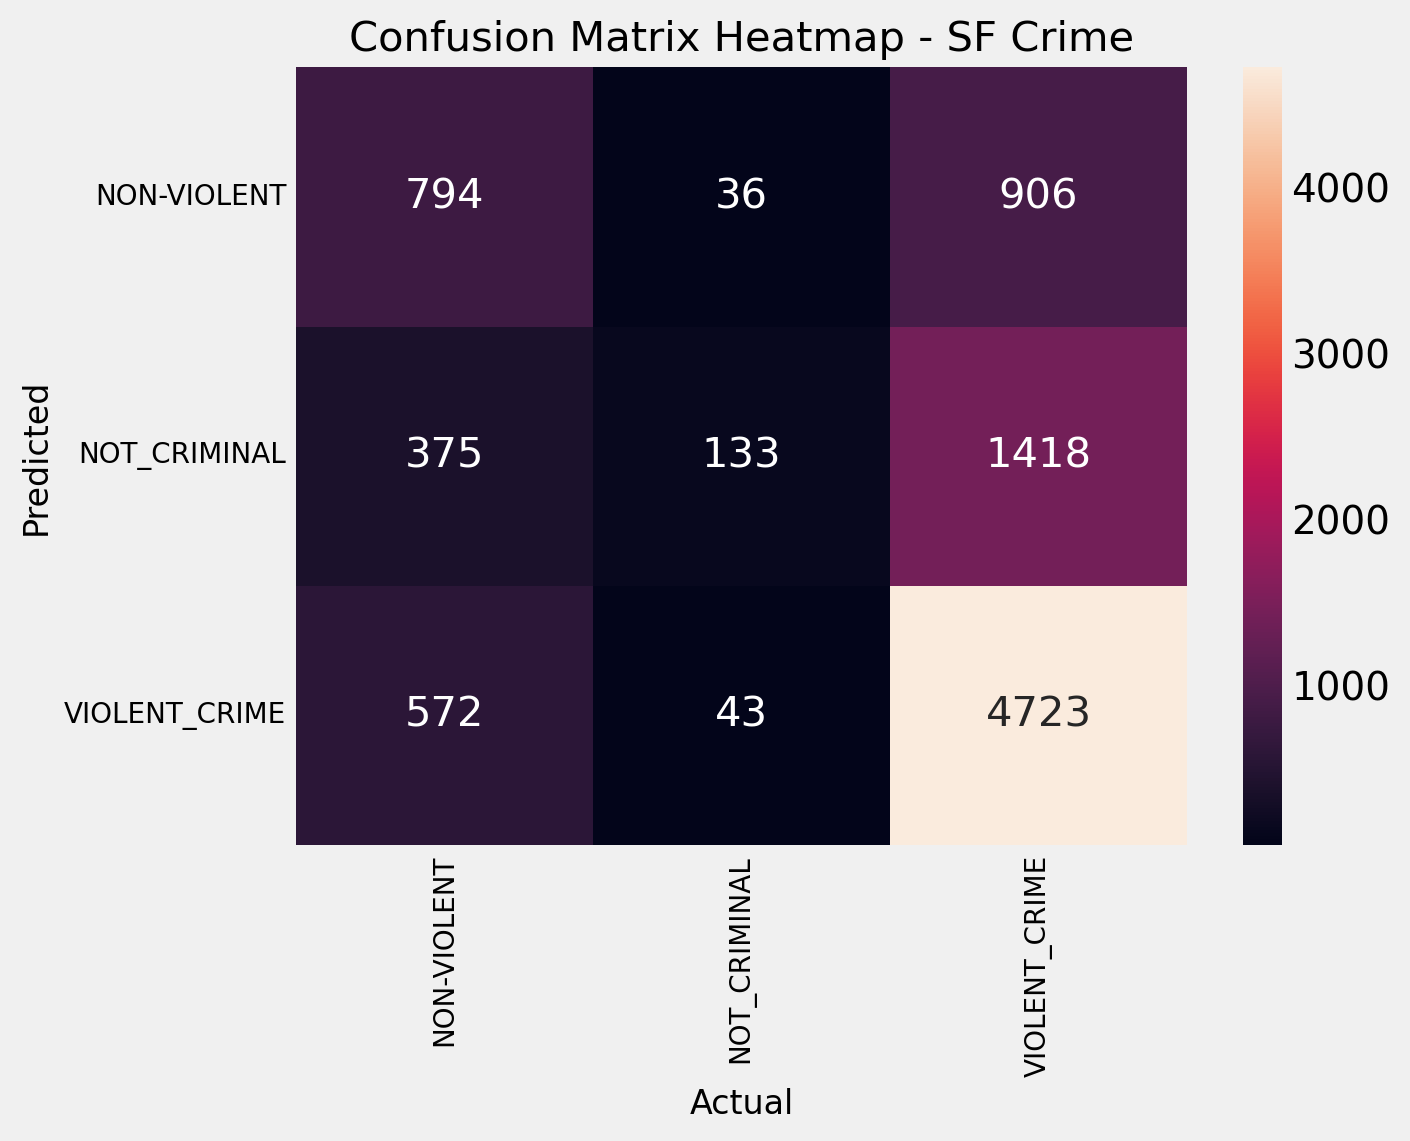

In [141]:
sns.heatmap(confusion, 
            annot=True,
            fmt = 'g',
            xticklabels = sorted(y_train.unique()), 
            yticklabels = sorted(y_train.unique()),
            annot_kws={'fontsize': 15})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.title('Confusion Matrix Heatmap - SF Crime', fontsize=15)
plt.show()

Through the confusion matrix we can see that a substantial amount of predictions were incorrectly classified when comparing to the true labels in the y_train set, which corresponds with the mean cross-validated accuracy of 62.77%.

### 7. Find the optimal hyperparameters (optimal regularization) to predict your crime categories using GridSearchCV.

> **Note:** Gridsearching can be done with `GridSearchCV` or `LogisticRegressionCV`. They operate differently - the gridsearch object is more general and can be applied to any model. The `LogisticRegressionCV` is specific to tuning the logistic regression hyperparameters. I recommend the logistic regression one, but the downside is that lasso and ridge must be searched separately. To start with, use `GridSearchCV`.

**Reference for logistic regression regularization hyperparameters:**
- `solver`: algorithm used for optimization (relevant for multiclass)
    - Newton-cg - Handles Multinomial Loss, L2 only
    - Sag - Handles Multinomial Loss, Large Datasets, L2 Only, Works best on scaled data
    - lbfgs - Handles Multinomial Loss, L2 Only
    - liblinear - Small Datasets, no Warm Starts
- `C`: Regularization strengths (smaller values are stronger penalties)
- `penalty`: `'l1'` - Lasso, `'l2'` - Ridge 

In [56]:
#create a hyperparameter dictionary for a logistic regression
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [57]:
#create a hyperparameter dictionary for a logistic regression (l2 only)
lr_paramsl2 = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'sag', 'lbfgs']
}

In [58]:
#create a gridsearch object using LogisticRegression() and the dictionary you created above
LRgrid = GridSearchCV(LogisticRegression(max_iter = 10000), lr_params, verbose = 3)

In [59]:
#create a gridsearch object using LogisticRegression() and the dictionary you created above (l2 only)
LRgridl2 = GridSearchCV(LogisticRegression(max_iter = 1000), lr_paramsl2, verbose = 3)

In [60]:
#fit the gridsearch object on your training data
LRgrid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.593 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.593 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.593 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.593 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.593 total time=   0.0s
[CV 1/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.593 total time=   0.0s
[CV 2/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.593 total time=   0.0s
[CV 3/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.593 total time=   0.0s
[CV 4/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.593 total time=   0.0s
[CV 5/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.593 total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.631 total time=   0.0s
[CV 2/5] END C=0.001, penalty

C:\Users\Mazza\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ......C=1, penalty=l1, solver=saga;, score=0.621 total time=  43.3s
[CV 3/5] END ......C=1, penalty=l1, solver=saga;, score=0.632 total time=   1.8s
[CV 4/5] END ......C=1, penalty=l1, solver=saga;, score=0.619 total time=   1.6s
[CV 5/5] END ......C=1, penalty=l1, solver=saga;, score=0.636 total time=  26.1s
[CV 1/5] END .C=1, penalty=l2, solver=liblinear;, score=0.631 total time=   0.0s
[CV 2/5] END .C=1, penalty=l2, solver=liblinear;, score=0.622 total time=   0.0s
[CV 3/5] END .C=1, penalty=l2, solver=liblinear;, score=0.631 total time=   0.0s
[CV 4/5] END .C=1, penalty=l2, solver=liblinear;, score=0.617 total time=   0.0s
[CV 5/5] END .C=1, penalty=l2, solver=liblinear;, score=0.637 total time=   0.0s
[CV 1/5] END ......C=1, penalty=l2, solver=saga;, score=0.630 total time=   0.9s
[CV 2/5] END ......C=1, penalty=l2, solver=saga;, score=0.621 total time=   1.1s
[CV 3/5] END ......C=1, penalty=l2, solver=saga;, score=0.632 total time=   0.9s
[CV 4/5] END ......C=1, pena

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=3)

In [61]:
#fit the gridsearch object on your training data (l2 only)
LRgridl2.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END C=0.001, penalty=l2, solver=newton-cg;, score=0.618 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l2, solver=newton-cg;, score=0.613 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l2, solver=newton-cg;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l2, solver=newton-cg;, score=0.614 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l2, solver=newton-cg;, score=0.620 total time=   0.0s
[CV 1/5] END ...C=0.001, penalty=l2, solver=sag;, score=0.618 total time=   0.0s
[CV 2/5] END ...C=0.001, penalty=l2, solver=sag;, score=0.613 total time=   0.0s
[CV 3/5] END ...C=0.001, penalty=l2, solver=sag;, score=0.619 total time=   0.0s
[CV 4/5] END ...C=0.001, penalty=l2, solver=sag;, score=0.614 total time=   0.0s
[CV 5/5] END ...C=0.001, penalty=l2, solver=sag;, score=0.620 total time=   0.0s
[CV 1/5] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.618 total time=   0.0s
[CV 2/5] END .C=0.001, penalty=l2

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'lbfgs']},
             verbose=3)

In [62]:
#print out the best parameters
print(LRgrid.best_params_)

{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


In [63]:
#print out the best parameters (l2 only)
print(LRgridl2.best_params_)

{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [64]:
#print out the best mean cross-validated score
print(LRgrid.best_score_) 
print(LRgridl2.best_score_)

0.6291111111111111
0.6278888888888889


Out of the different parameters used for GridSearch, best is when we used l2 penalty on liblinear solver with 0.001 regularisation, noting that by default liblinear solver automatically implements a one-vs-rest strategy to deal with the multiclasses.

In [65]:
#assign your best estimator to the variable 'best_logreg'
best_logreg = LRgrid.best_estimator_

In [67]:
#score your model on your testing data
LRgrid.score(X_test_scaled, y_test)

0.6345555555555555

### 8. Print out a classification report for your best_logreg model

In [135]:
#use your test data to create your classification report
predictions_best = LRgrid.predict(X_test_scaled)
print('Logistic Regression Classification Accuracy (Grid Search):', accuracy_score(y_test, predictions_best))
print('\n')
print(confusion_matrix(y_test, predictions_best))
print('\n')
print(classification_report(y_test, predictions_best))

Logistic Regression Classification Accuracy (Grid Search): 0.6345555555555555


[[ 834   36  866]
 [ 353  144 1429]
 [ 564   41 4733]]


               precision    recall  f1-score   support

  NON-VIOLENT       0.48      0.48      0.48      1736
 NOT_CRIMINAL       0.65      0.07      0.13      1926
VIOLENT_CRIME       0.67      0.89      0.77      5338

     accuracy                           0.63      9000
    macro avg       0.60      0.48      0.46      9000
 weighted avg       0.63      0.63      0.57      9000



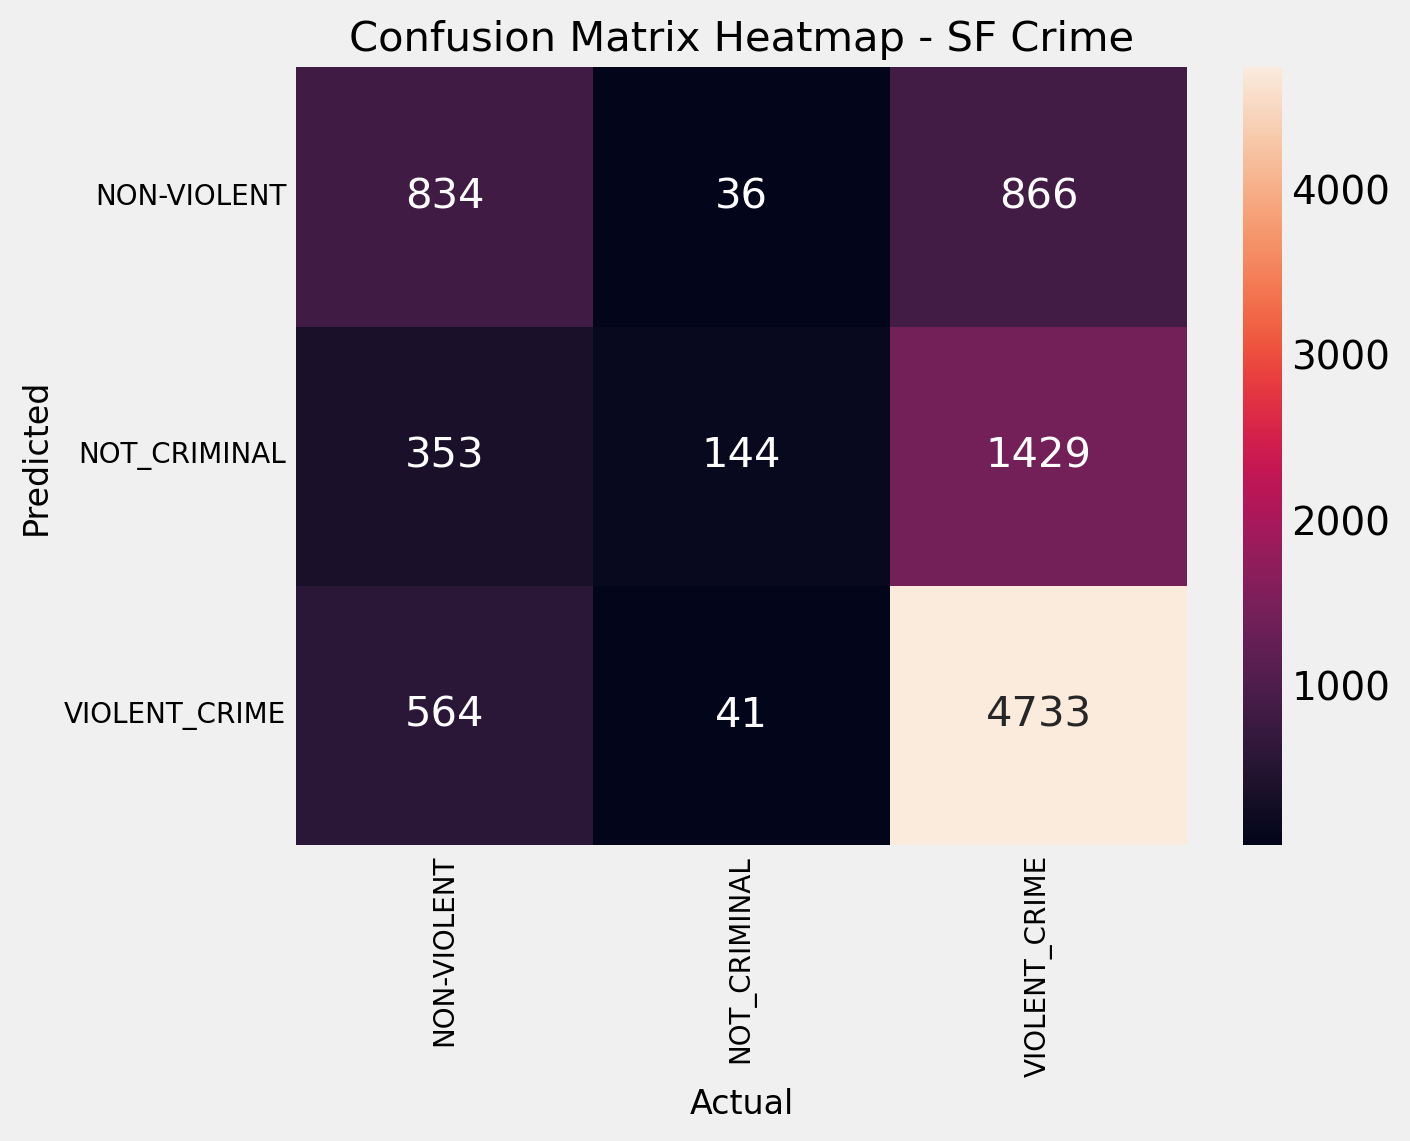

In [136]:
sns.heatmap(confusion_matrix(y_test, predictions_best),
            annot=True,
            fmt = 'g',
            xticklabels = sorted(y_train.unique()), 
            yticklabels = sorted(y_train.unique()),
            annot_kws={'fontsize': 15})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.title('Confusion Matrix Heatmap - SF Crime', fontsize=15)
plt.show()

We can visualise through tthe heatmap and classification report that by optimising with the best parameters with grid search we have slightly improved the overall accuracy score by 0.68%.

### 9. Explore LogisticRegressionCV.  

With LogisticRegressionCV, you can access the best regularization strength for predicting each class! Read the documentation and see if you can implement a model with LogisticRegressionCV.

In [75]:
# A:

# create model
LRcv = LogisticRegressionCV()

# fit model
LRcv.fit(X_train_scaled, y_train)

# get best regularisation strength for each each
print("Best regularization strength for each class:")
for i, class_label in enumerate(LRcv.classes_):
    print(f"Class {class_label}: {LRcv.C_[i]}")

best_regularisation = LRcv.C_


Best regularization strength for each class:
Class NON-VIOLENT: 0.005994842503189409
Class NOT_CRIMINAL: 0.005994842503189409
Class VIOLENT_CRIME: 0.005994842503189409


In [78]:
LR_best = LogisticRegression(C=0.005994842503189409, multi_class='auto')

LR_best.fit(X_train_scaled, y_train)

pred = LR_best.predict(X_test_scaled)

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.6342222222222222
